# LAB de cierre: Proceso de detección de caras

## 1. Introducción

En el curso hemos explorado una serie (bastante larga, por cierto) de concepto y algoritmos centrales de Machine Learning. Ahora bien, en el mundo real las aplicaciones de este tipo de técnicas no suelen ser tan directas como las que hemos visto aquí. Los datasets reales son ruidosos, heterogéneos, inconsistentes, con datos perdidos (variables o casos). En muchis casos no es tan simple construir un dataset de [n_filas, n_features]. Por eso, siempre la etapa previa de preprocesamiento y limpieza de los datos es central. Como hemos visto en el módulo no hay UNA receta para poder realizar la limpieza y la extracción de features de nuestro datasets. Cada problema, cada dataset requerirá un enfoque ad-hoc y una aproximación específica. Esa capacidad de "flexibilidad" en los enfoques es una característica del científico de datos.

En este módulo hemos visto varias aplicaciones de apredizaje no supervisado a imágenes y hemos visto algunos ejemplos en los que se usaban features a nive de pixles para clasificación. En aplicaciones reales, no es tan común encontrar datasets tan uniformes y, por eso, generalmente los pixels "crudos" no son utilizables directamente. Hay una gran cantidad de literatura acerca de los métodos para la extracción de features para imágenes.

En este LAB vamos a ver una de esas técnicas de extracción: [HOG (acrónimo de Histogram of Oriented Gradients)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients). Esta técnica transforma los pixeles de las imágenes en un representación vectorial que es sensible la información en los features de una imagen, tratando de "filtrar" los factores confusores como la iluminación. Usaremos estos fueatrues para desarrollar un pipeline de detección de caras.



#### Algunas referencias extra:

* **[Intuición de la noción de gradiente de una imágen](https://www.cs.cmu.edu/~ggordon/imageproc/gradview.html)**
* **[Definición más exhaustiva del cálculo de Histogram of Gradientes](http://www.learnopencv.com/histogram-of-oriented-gradients)**

Primero, importemos los paquetes a utilizar:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 2. HOG features

El histograma de graidentes es una forma muy directa de extracción de features desarrollada en el contexto de la identificación de peatones en imágenes. HOG involucra los siguientes pasos:

   1. Opcionalmente, prenoramlizar las imágenes: esto hace que el procedimiento sea robusto a variaciones en la ilumniación
   2. Convolucionar la imagen con dos filtros que sean sensibles a los gradientes de brillo horizontal y vertical. Estos captan información de contorno, contorno y textura.
   3. Subdividir la imagen en celdas de un tamaño predeterminado y computar un HOG dentro de cada celda
   4. Normalizar los histogramas en cada celda comparandolos con las celdas vecinas. Esto tiende a suprimir el efeto de la iluminación a lo largo de la imagen
   5. Construir un vector unidimensional de la información de la celda.

Un extractor [HOG](http://scikit-image.org/docs/stable/api/skimage.feature.html#hog) rápido está incluido en el proyecto [Scikit-Image](http://scikit-image.org/) y podemos visualizar de forma bastante rápida los gradientes de cada celda.

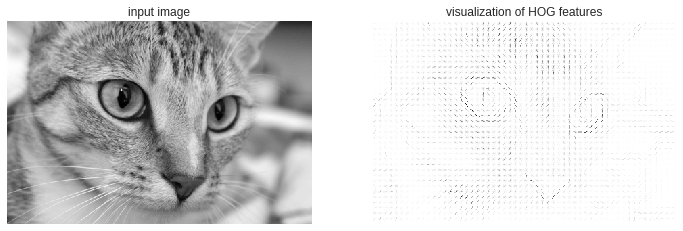

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True, block_norm='L2-Hys')

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## 3. HOG en acción: Un detector de caras simple

Usando estas features HOG podemos construir un algoritmo detector de caras usando cualquier estimador de Scikit-Learn. Aquí vamos a usar SVM. Más adelante podrán probar otros métodos. Veamos los pasos a seguir:

   1. Obtener un set de imágenes thumbnails de caras para construir un training de "positivos"
   2. Obtener un set de imágenes thumbnails que no sean de caras para construir un training de "negativos"
   3. Extraer features HOG de cada uno de los dos conjuntos
   4. Entrenar un SVM linear para clasificar el training seg
   5. Para una imagen "nueva" pasar una ventana móvil a lo largo de la imagen, usando el modelo para evaluar si esa ventana contiene una cara o  no.
   6. Si las detecciones se solapan, combinarlas en una sola ventana.

### 3.1 Obtener un set de samples positivas

Comencemos obteniendo algunas imágenes con caras diversas. Podemos trabajar fácilmente con las imágenes taggeadas como caras del Wild dataset que ya hemos usado.

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

Tenemos, entonces, 13.000 caras para trabajar.

### 3.2 Obtener un dataset de samples negativas

Ahora necesitamos un set de thumbnails de tamaño similar pero que no contengan caras en ellas. Una forma de hacer esto es tomar un corpus de imágenes cualquiera y extraer thumbnails en una variedad de escalas. Aquí podemos usar algunas de las imágenes que vienen con Scikit-Image, junto con el PatchExtractor de Scikit-Learn.

In [4]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

/home/digitalhouse/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(30000, 62, 47)

Ahora tenemos 30.000 imágenes que no contienen caras. Veamos algunas para tener una idea de qué son...

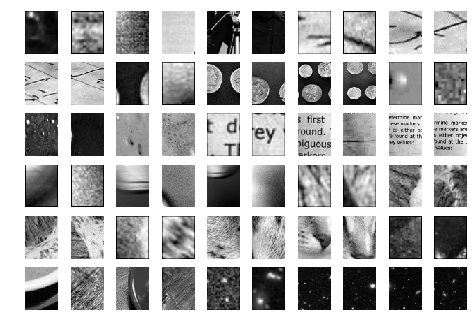

In [6]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

### 3.3 Combinar los datasets y extraer los features HOG

Ahora que tenemos samples negativas y positivas, podemos combinar ambos y computar los HOGs. Este paso puede tomar un tiempo porque implica cómputos de cierta complejidad en cada imagen.

In [7]:
from itertools import chain
X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

/home/digitalhouse/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Para no tener que repetir todo el proceso la próxima, podemos guardar los resultados en un archivo .dump para poder recuperarlo luego. Para ello, concatenarmos `X_train` e `y_train` en un diccionario y luego hacemos un dump.

In [8]:
pipe_faces = dict({'data': X_train, 'target' : y_train})

In [9]:
import joblib
pipe_faces = joblib.dump(pipe_faces, "./pipe_faces.dump")

Luego, si deseáramos cargarlo en otro momento podríamos correr la siguiente celda:

In [10]:
import joblib
pipe_faces = joblib.load("./pipe_faces.dump")
X_train = pipe_faces['data']
y_train = pipe_faces['target']

Tenemos, entonces, 43.000 training samples en 1.215 dimensiones para trabajar.

### 3.4 Entrenar un clasificador SVM lineal

Ahora, la idea es utilizar alguna de las herramientas que estuvimos explorando para crear un clasificador de imágenes. Tenemos, entonces, un problema de clasificación binaria en un dataset de alta dimensionalidad. Para este tipo de tareas un clasificador lineal basado en support vector machines es un buen candidato. 

Entrenemos un modelo Naïve Bayes gaussiano para utilizar como una línea de base:

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train).mean()

0.93338422038720414

Vemos, entonces, que en nuestro dataset un simple algoritmo basado en Bayes obtiene un accuracy del 90%. Probemos, entonces, un SVM con un grid search sobre el parámetro C.

In [12]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.98630675641292531

In [13]:
grid.best_params_

{'C': 1.0}

Tomemos el mejor estimador y re-entremos el modelo en el dataset completo:

In [14]:
model_svc = grid.best_estimator_
model_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_svc, X_train, y_train, n_jobs=4).mean()

0.98630675641292542

### 3.5 Encontrar caras en una imagen nueva

Ahora que tenemos nuestro modelo entrenado, tomemos una imagen para evaluar cómo funciona. Usaremos una porción de una imagen, correremos una ventana móvil a lo largo de la misma y evaluaremos cada porción:

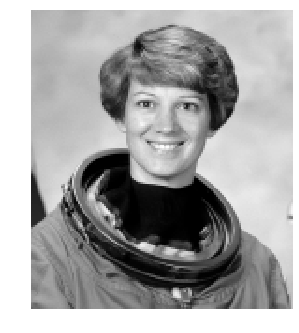

In [16]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

A continuación, creemos la ventana que itera sobre porciones de la imagen y computa las HOG features para cada porción:

In [17]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

Por último, podemos tomar estas porciones de features HOG y usar el modelo para evaluar cuáles contienen una cara:

In [18]:
labels = model_svc.predict(patches_hog)
labels.sum()

28.0

Podemos ver que de las 2.000 porciones encontramos 28 detecciones. Grafiquemos las porciones sobre nuestra imágen para ver en qué zona caen:

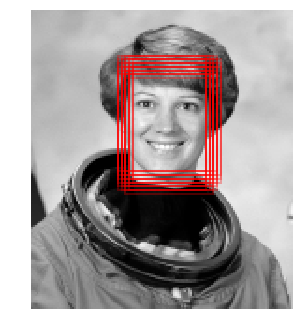

In [19]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Todas las porciones se solapan y logran detectar la cara en la imagen...

## BONUS A: Probar con otros modelos

En este punto, podría ser de interés evaluar la performance de otros modelos que permitan realizar la clasificación de caras en las imágenes que tomamos.¿Qué tan bien funcionan Random Forest y Gradient Boosting en comparación con SVM?

### Usando `RandomizedSearchCV`
### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
params_rs_rf = {'max_depth': np.arange(1,30,5),
          'max_features' : np.arange(1,100,10),
          'n_estimators' : np.arange(1,200,10)}

n_iter_search = 10
randsearch_rf = RandomizedSearchCV(RandomForestClassifier()
                                   , param_distributions=params
                                   , n_iter=n_iter_search
                                   , n_jobs = 4
                                   , verbose = 2)
                                   
randsearch_rf.fit(X_train, y_train)
randsearch_rf.best_score_

In [ ]:
model_rs_rf = randsearch_rf.best_estimator_
model_rs_rf.fit(X_train, y_train, n_jobs=4)

In [ ]:
cross_val_score(model_rs_rf, X_train, y_train, n_jobs=4).mean()

### Gradient Boosting

In [22]:
params_rs_gb = {'learning_rate' : [0.1, 0.01, 0.001, 0.0001],
          'max_depth': np.arange(1,30,5),
          'max_features' : np.arange(1,100,10),
          'n_estimators' : np.arange(1,500,10)}

n_iter_search = 10
randsearch_gb = RandomizedSearchCV(GradientBoostingClassifier()
                                   , param_distributions=params_rs_gb
                                   , n_iter=n_iter_search
                                   , n_jobs = 4
                                   , verbose = 1)
                                   

randsearch_gb.fit(X_train, y_train)
randsearch_gb.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 87.5min finished


0.98695440982582749

In [ ]:
model_rs_gb = randsearch_gb.best_estimator_
model_rs_gb.fit(X_train, y_train, n_jobs=4)

### Usando `GridSearchCV`
### Random Forest

In [ ]:
grid_rf = GridSearchCV(RandomForestClassifier(n_estimators=100, oob_score=False)
                    , {'max_features': [50,70,90]}
                    , cv=3
                    , n_jobs=4
                    , verbose=2)

grid_rf.fit(X_train, y_train)
grid_rf.best_score_

In [ ]:
grid_rf.best_estimator_

In [ ]:
model_grid_rf = grid_rf.best_estimator_
model_grid_rf.fit(X_train, y_train, n_jobs=4)

In [ ]:
cross_val_score(model_grid_rf, X_train, y_train, n_jobs=4).mean()

### Gradient Boosting

In [ ]:
grid_gb = GridSearchCV(GradientBoostingClassifier(n_estimators=100), 
                       {'learning_rate': [0.1, 0.001],
                        'max_features' : [50,70,90]}, 
                        n_jobs=4, verbose=2)


grid_gb.fit(X_train, y_train)
grid_gb.best_score_

In [ ]:
model_grid_gb = grid_gb.best_estimator_
model_grid_gb.fit(X_train, y_train, n_jobs=4)

In [ ]:
cross_val_score(model_grid_gb, X_train, y_train, n_jobs=4).mean()